In [ ]:
import torch
import pandas as pd
import numpy as np
import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import ViTForImageClassification
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
import wandb
import torch.nn.functional as F

In [ ]:
drive.mount('/content/drive')
image_folder = '/content/drive/MyDrive/Курсовая/images/'
masks_folder = '/content/drive/MyDrive/Курсовая/masks_full/'
metadata_path = '/content/drive/MyDrive/Курсовая/HAM10000_metadata.tab'

Mounted at /content/drive


Тут будет маска как ещё один канал

In [ ]:
df = pd.read_csv(metadata_path, sep='\t', header=None)
df.columns = ['lesion_id', 'image_id', 'diagnosis', 'type_of_diagnostic', 'age', 'sex', 'localization', 'source']
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_folder, x + '.jpg'))
df['mask_path'] = df['image_id'].apply(lambda x: os.path.join(masks_folder, x + '.png'))
df.head()

,lesion_id,image_id,diagnosis,type_of_diagnostic,age,sex,localization,source,image_path,mask_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...


In [ ]:
benign_diagnoses = ['bkl', 'nv', 'df', 'vasc']  # доброкачественные будут 1, злокачественные 0
df['label'] = df['diagnosis'].apply(lambda x: 0 if x in benign_diagnoses else 1)
df.head()

,lesion_id,image_id,diagnosis,type_of_diagnostic,age,sex,localization,source,image_path,mask_path,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0


In [ ]:
df.drop(columns=['diagnosis'], inplace=True)
df.head()

,lesion_id,image_id,type_of_diagnostic,age,sex,localization,source,image_path,mask_path,label
0,HAM_0000118,ISIC_0027419,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
1,HAM_0000118,ISIC_0025030,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
2,HAM_0002730,ISIC_0026769,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
3,HAM_0002730,ISIC_0025661,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
4,HAM_0001466,ISIC_0031633,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0


In [ ]:
train_df, tmp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(tmp_df, test_size=0.5, stratify=tmp_df['label'], random_state=42)

In [ ]:
wandb.init(project="skin_lesion_classification", config={
    "learning_rate": 0.0001,
    "epochs": 100,
    "batch_size": 16,
    "architecture": "ViT",
    "dataset": "HAM10000"})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kalinicheva2007 (pdftotex) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
config = wandb.config

In [ ]:
class ViTWithMask(torch.nn.Module):
    def __init__(self, vit_model):
        super(ViTWithMask, self).__init__()
        self.vit = vit_model

    def forward(self, pixel_values, seg_mask=None):
        # embeddings = self.vit.embeddings(pixel_values)
        embeddings = self.vit.vit.embeddings(pixel_values)
        if isinstance(embeddings, tuple):
            embeddings = embeddings[0]

        if seg_mask is not None:
            patch_size = self.vit.config.patch_size
            B, C, H, W = pixel_values.shape
            new_H, new_W = H // patch_size, W // patch_size

            seg_mask_resized = F.interpolate(seg_mask, size=(new_H, new_W), mode='nearest')
            seg_mask_flat = seg_mask_resized.view(B, -1)
            ones = torch.ones(B, 1, device=seg_mask_flat.device)
            seg_mask_flat = torch.cat([ones, seg_mask_flat], dim=1)
            seg_mask_flat = seg_mask_flat.float().unsqueeze(-1)
            embeddings = embeddings * seg_mask_flat

        # encoder_outputs = self.vit.encoder(embeddings)
        encoder_outputs = self.vit.vit.encoder(embeddings)
        if isinstance(encoder_outputs, tuple):
            hidden_states = encoder_outputs[0]
        else:
            hidden_states = encoder_outputs.last_hidden_state

        # cls_output = encoder_outputs[:, 0]
        cls_output = hidden_states[:, 0]
        if hasattr(self.vit, 'layernorm'):
            cls_output = self.vit.layernorm(cls_output)
        elif hasattr(self.vit, 'layer_norm'):
            cls_output = self.vit.layer_norm(cls_output)
        # else:
        #    pass
        # cls_output = self.vit.layernorm(cls_output)
        logits = self.vit.classifier(cls_output)
        return logits

In [ ]:
class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, image_transform=None, mask_transform=None):
        self.dataframe = dataframe
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        mask_path = self.dataframe.iloc[idx]['mask_path']
        label = self.dataframe.iloc[idx]['label']

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask, label


image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.ToTensor()])

train_dataset = SkinLesionDataset(train_df, image_transform=image_transform, mask_transform=mask_transform)
val_dataset = SkinLesionDataset(val_df, image_transform=image_transform, mask_transform=mask_transform)
test_dataset = SkinLesionDataset(test_df, image_transform=image_transform, mask_transform=mask_transform)

train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_name = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(model_name, num_labels=2).to(device)  # бинарная

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_with_mask = ViTWithMask(model).to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
optimizer = torch.optim.Adam(model_with_mask.parameters(), lr=config.learning_rate)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False, save_path='best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.save_path = save_path
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, model, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.save_path)
        if self.verbose:
            print(f'Сохранены новые лучшие веса модели в: {self.save_path}')

    def load_best_model(self, model):
        model.load_state_dict(torch.load(self.save_path))
        if self.verbose:
            print(f'Загружены лучшие веса модели из: {self.save_path}')

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, masks, labels in dataloader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            outputs = model(images, seg_mask=masks)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [ ]:
def train_model(num_epochs, model):
    early_stopping = EarlyStopping(patience=5, verbose=True, save_path='best_model.pth')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (images, masks, labels) in enumerate(train_dataloader):
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, seg_mask=masks)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}/{len(train_dataloader)}')
        train_loss = running_loss / total
        train_accuracy = 100 * correct / total

        val_loss, val_accuracy = evaluate(model, val_dataloader)

        wandb.log({
            'epoch': epoch+1,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy})

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        if early_stopping(model, val_loss):
            print('Early stopping triggered...')
            break

    early_stopping.load_best_model(model)

In [ ]:
train_model(num_epochs=config.epochs, model=model_with_mask)

Epoch 1, Batch 0/439
Epoch 1, Batch 10/439
Epoch 1, Batch 20/439
Epoch 1, Batch 30/439
Epoch 1, Batch 40/439
Epoch 1, Batch 50/439
Epoch 1, Batch 60/439
Epoch 1, Batch 70/439
Epoch 1, Batch 80/439
Epoch 1, Batch 90/439
Epoch 1, Batch 100/439
Epoch 1, Batch 110/439
Epoch 1, Batch 120/439
Epoch 1, Batch 130/439
Epoch 1, Batch 140/439
Epoch 1, Batch 150/439
Epoch 1, Batch 160/439
Epoch 1, Batch 170/439
Epoch 1, Batch 180/439
Epoch 1, Batch 190/439
Epoch 1, Batch 200/439
Epoch 1, Batch 210/439
Epoch 1, Batch 220/439
Epoch 1, Batch 230/439
Epoch 1, Batch 240/439
Epoch 1, Batch 250/439
Epoch 1, Batch 260/439
Epoch 1, Batch 270/439
Epoch 1, Batch 280/439
Epoch 1, Batch 290/439
Epoch 1, Batch 300/439
Epoch 1, Batch 310/439
Epoch 1, Batch 320/439
Epoch 1, Batch 330/439
Epoch 1, Batch 340/439
Epoch 1, Batch 350/439
Epoch 1, Batch 360/439
Epoch 1, Batch 370/439
Epoch 1, Batch 380/439
Epoch 1, Batch 390/439
Epoch 1, Batch 400/439
Epoch 1, Batch 410/439
Epoch 1, Batch 420/439
Epoch 1, Batch 430/439

In [ ]:
# model.load_state_dict(torch.load('/content/best_model.pth'))
# model.to(device)
model_with_mask.load_state_dict(torch.load('/content/best_model.pth'))
model_with_mask.to(device)

ViTWithMask(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermediate): ViTIntermediate(
              (dense): Linear(

In [ ]:
def evaluate_model():
    test_loss, test_accuracy = evaluate(model_with_mask, test_dataloader)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

evaluate_model()

Test Loss: 0.2712, Test Accuracy: 87.62%


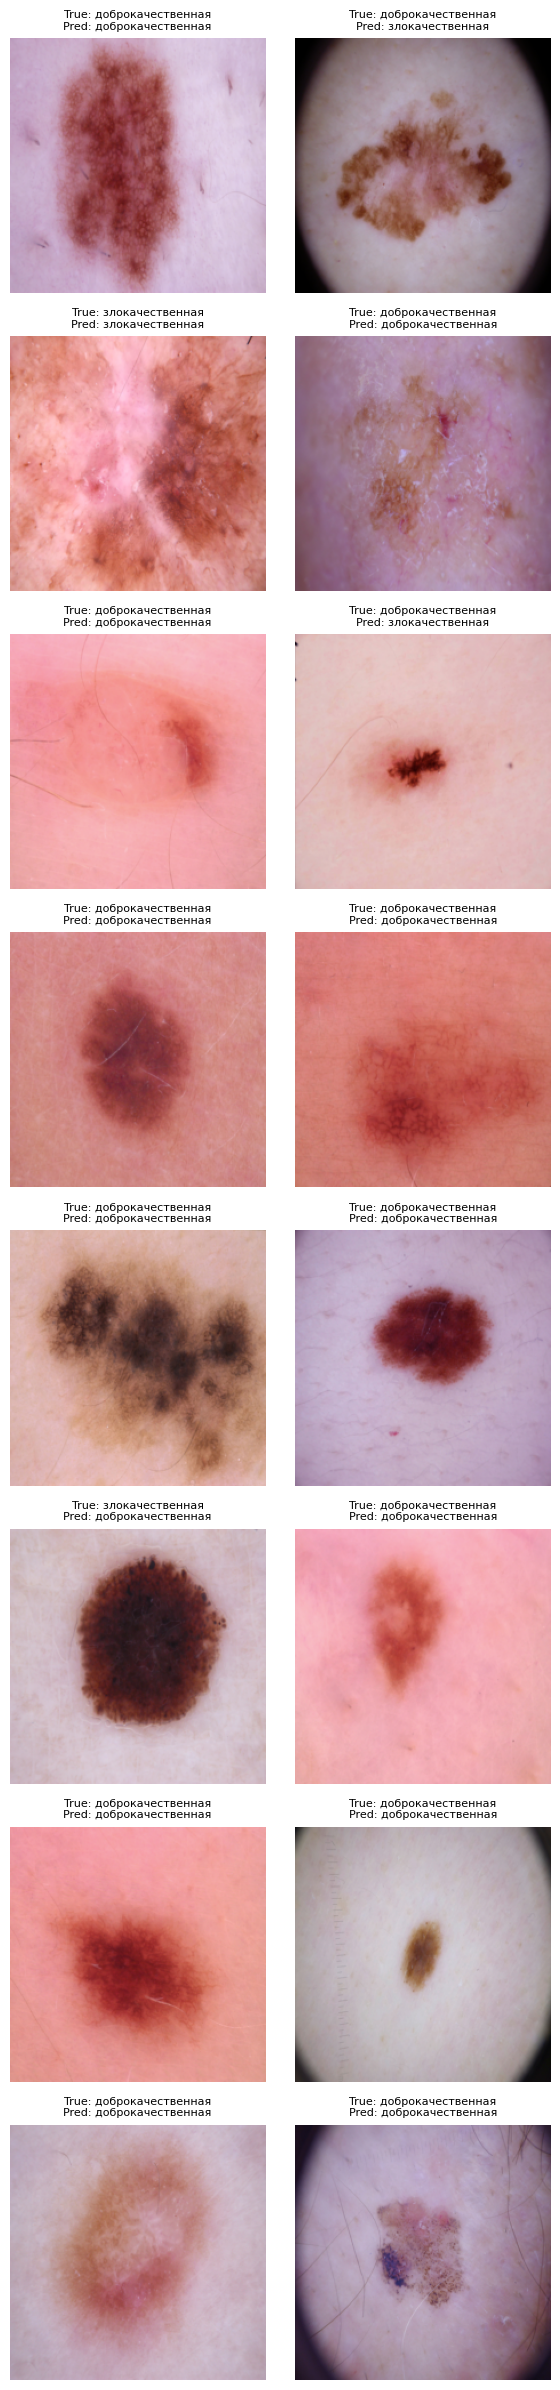

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, grid_shape=(8, 2)):
    model.eval()
    n_rows, n_cols = grid_shape
    total_images = n_rows * n_cols
    label_map = {0: 'доброкачественная', 1: 'злокачественная'}

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    # Преобразуем axes в одномерный массив для удобного перебора
    if isinstance(axes, (list, np.ndarray)):
        axes = axes.flatten()
    else:
        axes = [axes]

    images_shown = 0

    with torch.no_grad():
        for images, masks, labels in dataloader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            outputs = model(images, seg_mask=masks)
            _, preds = torch.max(outputs, 1)
            images = images.cpu()
            for i in range(images.shape[0]):
                if images_shown >= total_images:
                    break
                img = images[i].permute(1, 2, 0)
                img = img * 0.5 + 0.5
                ax = axes[images_shown]
                ax.imshow(img.numpy())
                true_label = label_map[labels[i].item()]
                pred_label = label_map[preds[i].item()]
                ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
                ax.axis('off')
                images_shown += 1
            if images_shown >= total_images:
                break
    plt.tight_layout()
    plt.show()

visualize_predictions(model_with_mask, test_dataloader, grid_shape=(8, 2))

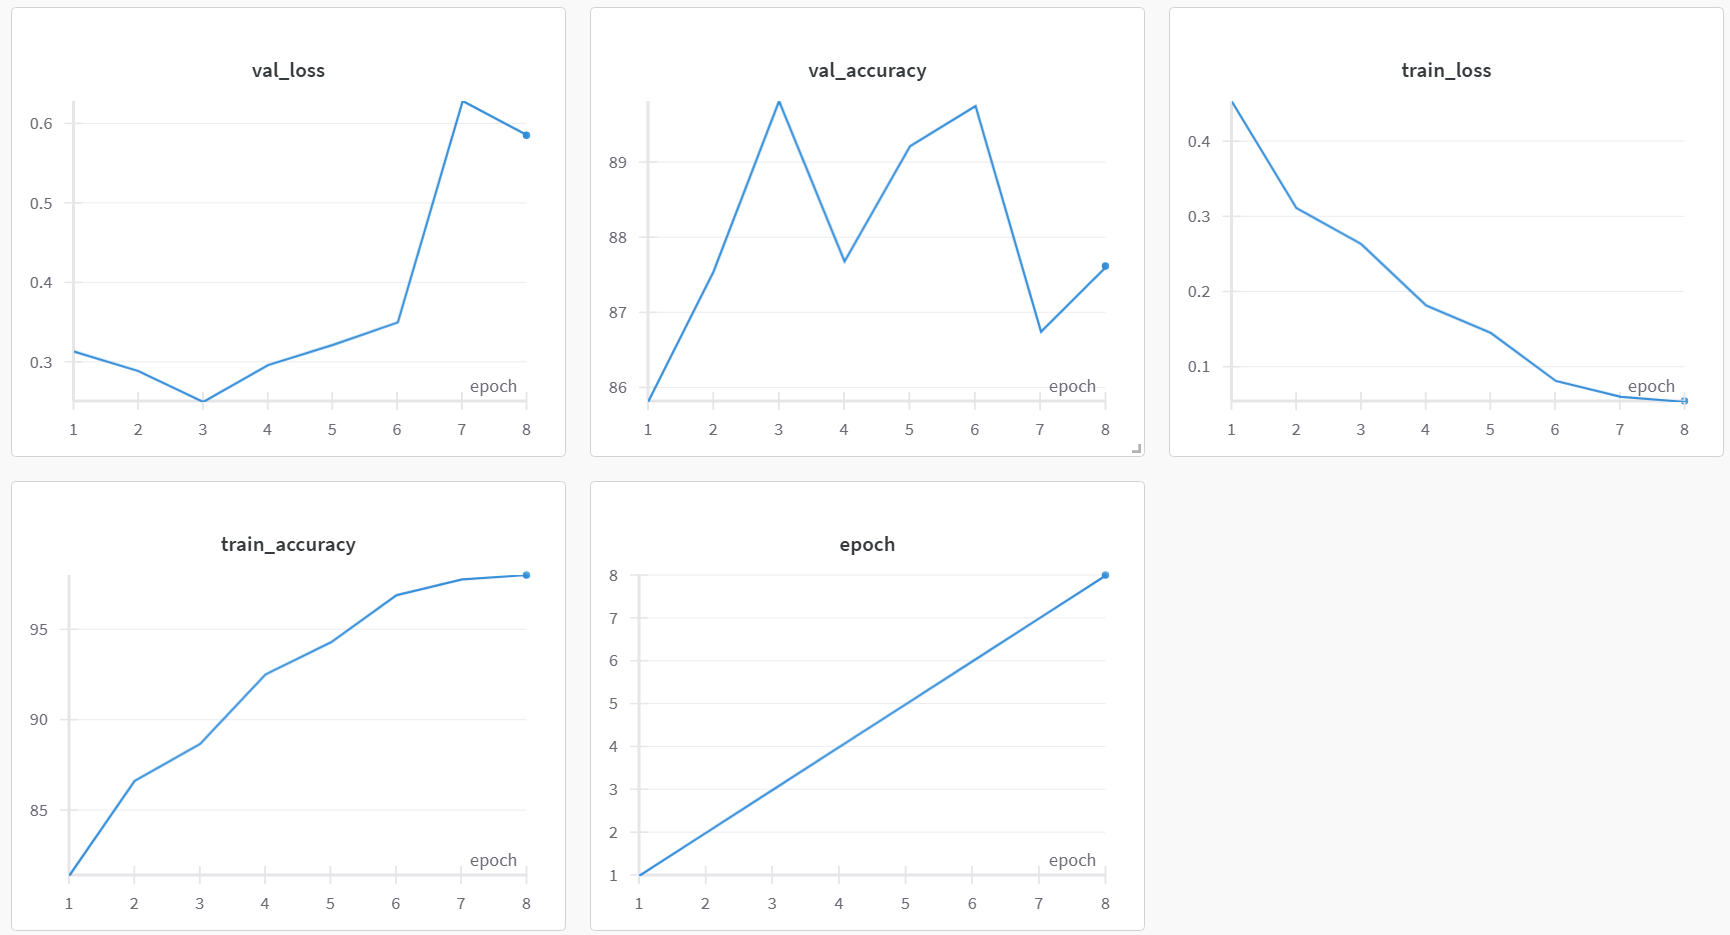

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 7
microcode	: 0xffffffff
cpu MHz		: 2200.154
cache size	: 39424 KB
physical id	: 0
siblings	: 12
core id		: 0
cpu cores	: 6
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp ibrs_enhanced fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat avx512_vnni md_clear arch_capabilities
bugs		: spectre_v1 spectre_v2 spec_store_bypass swapgs ta

In [ ]:
import torchvision
print('torch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
